In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, SeasonalNaive)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-01-08,AAPL,0.013896
1,2019-01-15,AAPL,0.044463
2,2019-01-22,AAPL,-0.003321
3,2019-01-29,AAPL,0.091347
4,2019-02-05,AAPL,-0.010684
...,...,...,...
2075,2023-11-28,NVDA,-0.058298
2076,2023-12-05,NVDA,0.024248
2077,2023-12-12,NVDA,0.071470
2078,2023-12-19,NVDA,-0.025217


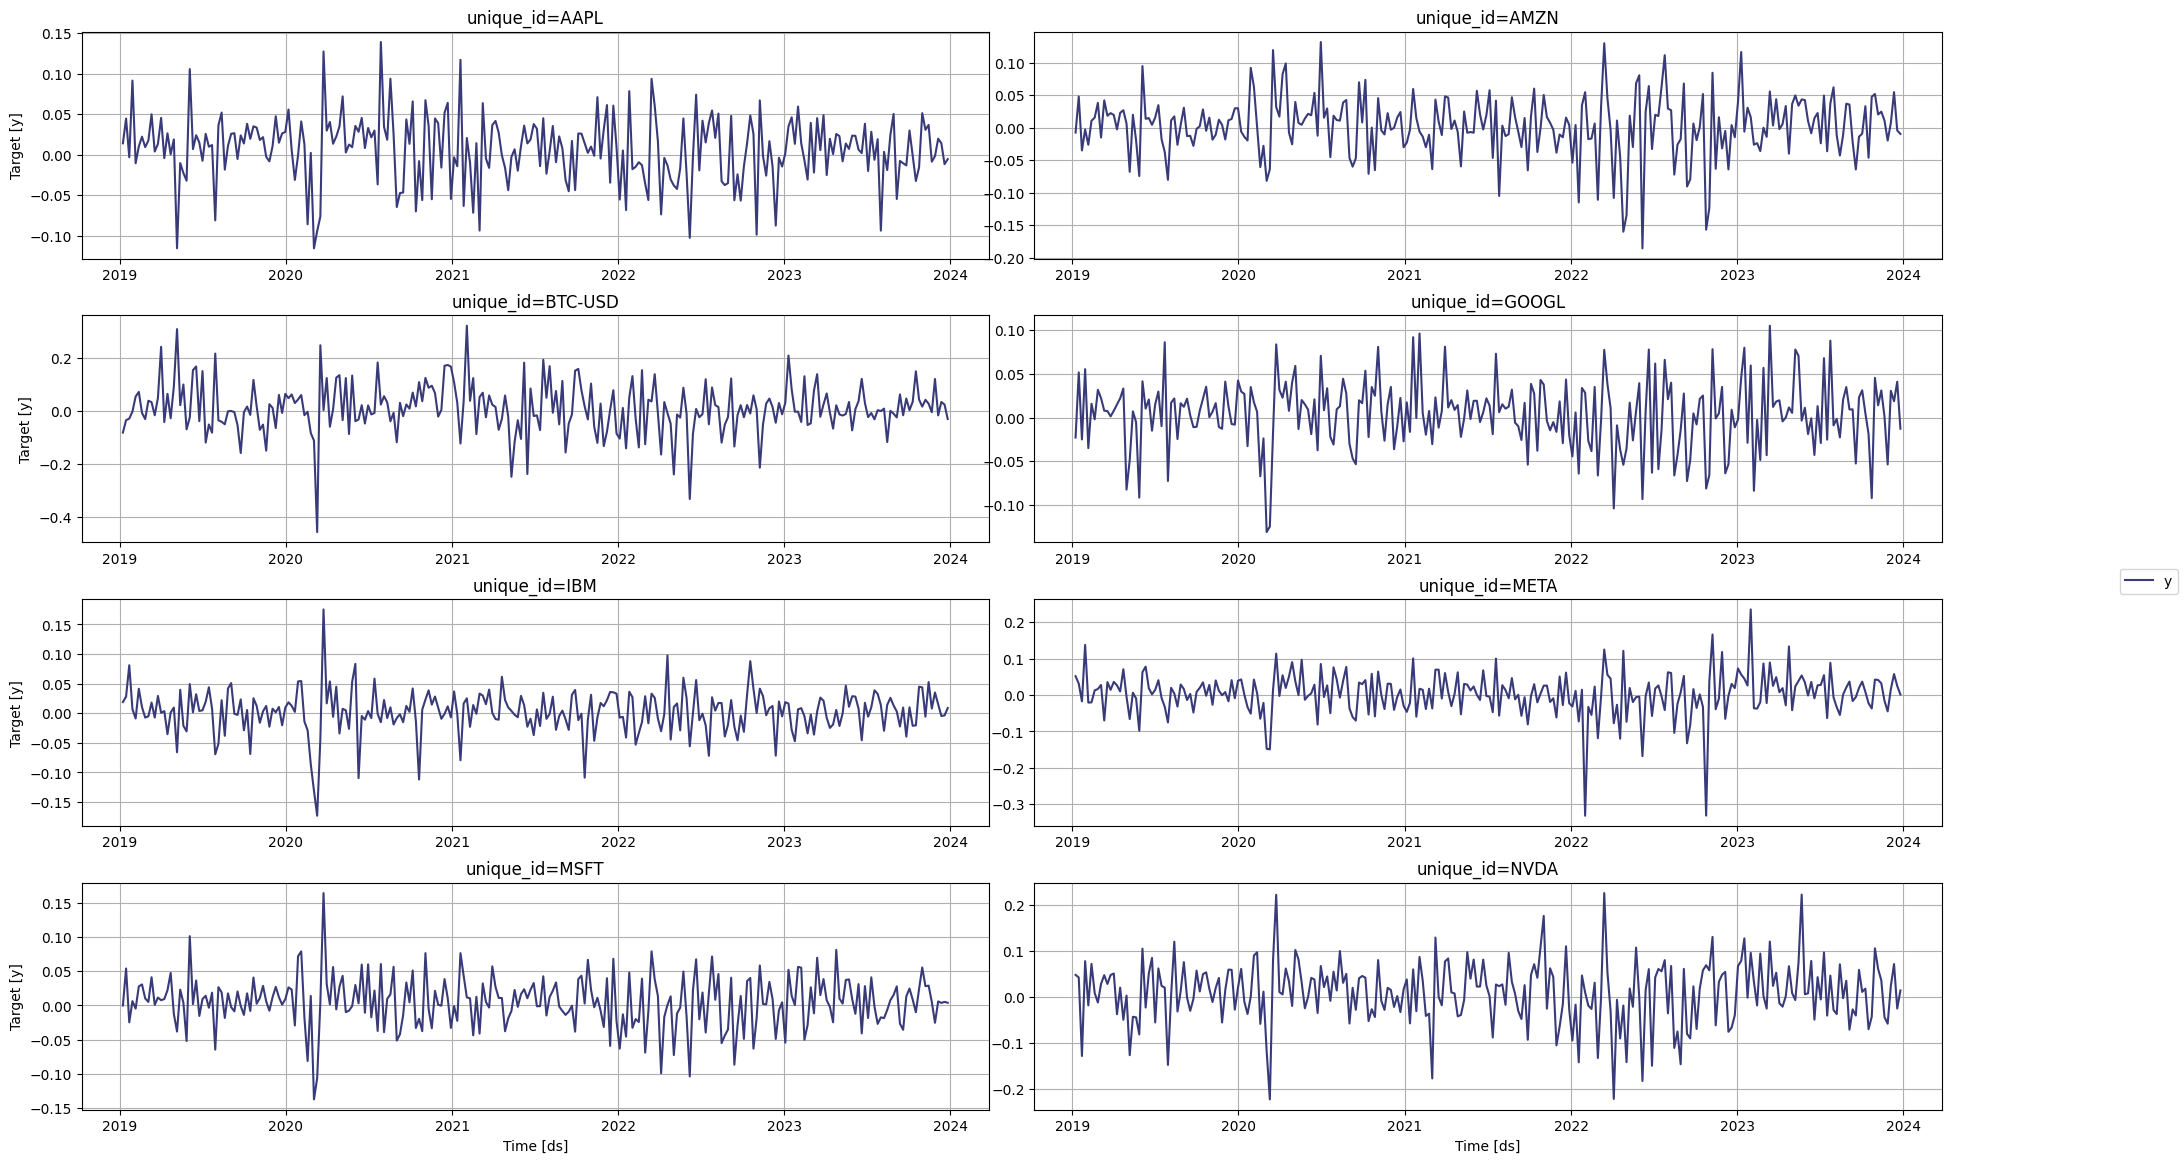

In [7]:
StatsForecast.plot(Y_df)

In [8]:
season_length = 52
horizon = 4

models = [
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [9]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,AutoARIMA,SeasonalNaive
unique_id,,,
AAPL,2023-12-31,0.0,0.001692
AAPL,2024-01-07,0.0,0.034808
AAPL,2024-01-14,0.0,0.046044
AAPL,2024-01-21,0.0,0.013305
AMZN,2023-12-31,0.0,0.039221


In [10]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
AAPL,2023-08-15,2023-08-08,-0.019028,0.0,-0.069832,0.069832,-0.032988,-0.138910,0.072934
AAPL,2023-08-22,2023-08-08,0.024437,0.0,-0.069832,0.069832,-0.037639,-0.143562,0.068283
AAPL,2023-08-29,2023-08-08,0.050166,0.0,-0.069832,0.069832,-0.035124,-0.141047,0.070798
AAPL,2023-09-05,2023-08-08,-0.054783,0.0,-0.069832,0.069832,0.047747,-0.058175,0.153670
AAPL,2023-09-12,2023-09-05,-0.007780,0.0,-0.069774,0.069774,-0.056320,-0.162591,0.049951


In [11]:
cv_df.tail()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,
NVDA,2023-11-28,2023-10-31,-0.058298,0.0,-0.113507,0.113507,0.048288,-0.118700,0.215275
NVDA,2023-12-05,2023-11-28,0.024248,0.0,-0.113101,0.113101,0.054450,-0.112160,0.221059
NVDA,2023-12-12,2023-11-28,0.071470,0.0,-0.113101,0.113101,-0.075860,-0.242469,0.090749
NVDA,2023-12-19,2023-11-28,-0.025217,0.0,-0.113101,0.113101,-0.066649,-0.233258,0.099961
NVDA,2023-12-26,2023-11-28,0.014072,0.0,-0.113101,0.113101,-0.039710,-0.206319,0.126899


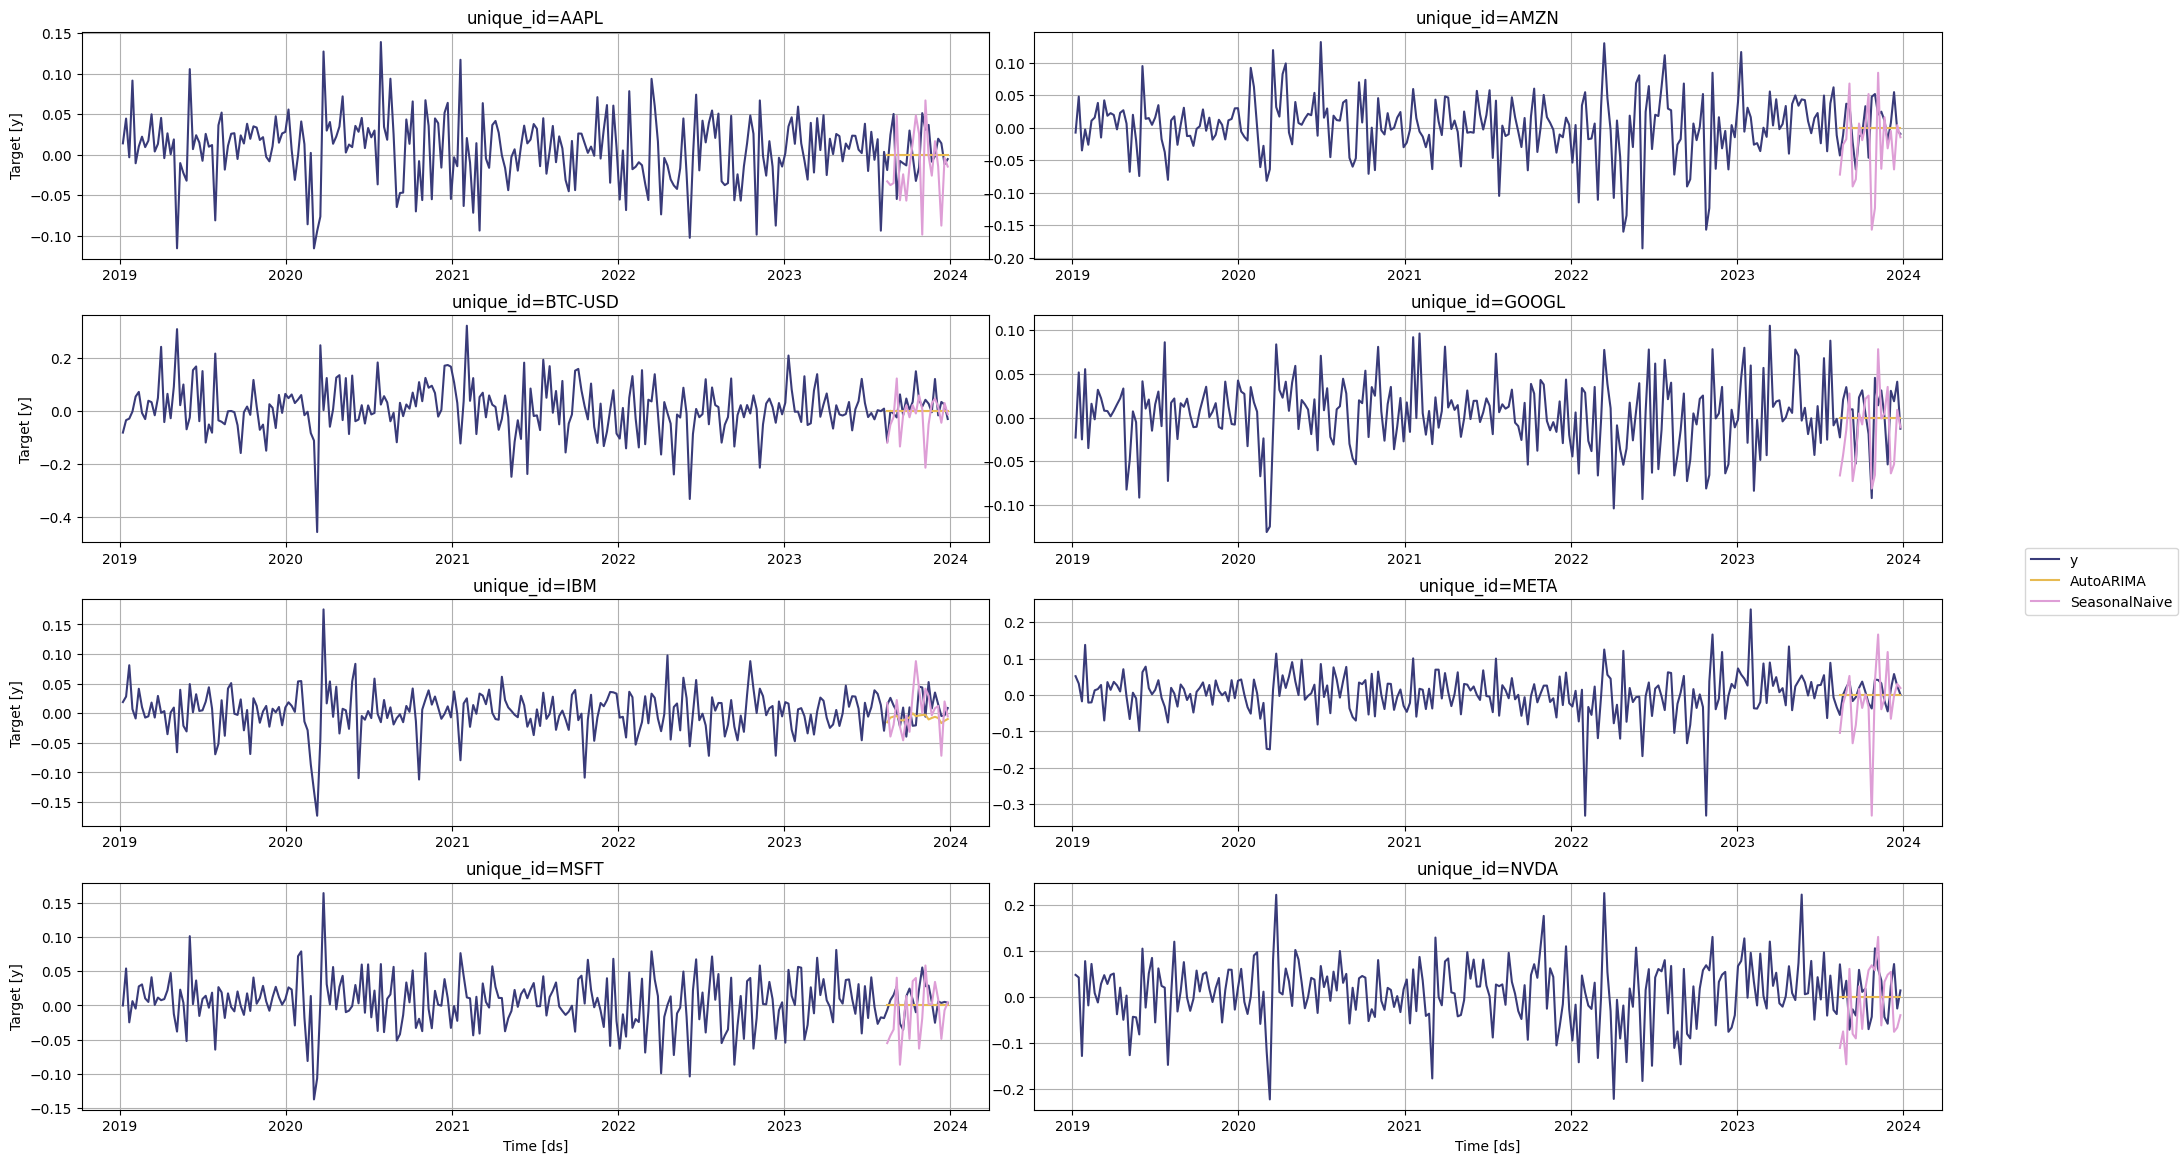

In [12]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [13]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [14]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [15]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [16]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [17]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 15:44:25,327 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9126b44b491d641573991471b7fcea1d initialized by task ('shuffle-transfer-9126b44b491d641573991471b7fcea1d', 3) executed on worker tcp://127.0.0.1:57678
2024-07-09 15:44:29,124 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9126b44b491d641573991471b7fcea1d deactivated due to stimulus 'task-finished-1720532669.122002'


,unique_id,cutoff,metric,AutoARIMA,SeasonalNaive
0,BTC-USD,2023-10-03,mse,0.006292,0.006453
1,BTC-USD,2023-10-03,mae,0.059798,0.049328
2,BTC-USD,2023-10-03,smape,200.0,93.85257
3,BTC-USD,2023-11-28,mse,0.000727,0.00187
4,BTC-USD,2023-11-28,mae,0.026236,0.0333


In [18]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

AutoARIMA  SeasonalNaive
cutoff     metric                           
2023-08-08 mae       0.029945       0.054316
           mse       0.001491       0.005179
           smape        200.0     139.281876
2023-09-05 mae         0.0253       0.044244
           mse       0.000913       0.003531
           smape   193.303741     121.498344
2023-10-03 mae       0.039286       0.069619
           mse       0.002477       0.009538
           smape   197.445801     144.648834
2023-10-31 mae        0.03094        0.05791
           mse       0.001506       0.006072
           smape   196.120773     146.750198
2023-11-28 mae       0.020357       0.038887
           mse       0.000684       0.002957
           smape   194.445618     140.225021

In [19]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

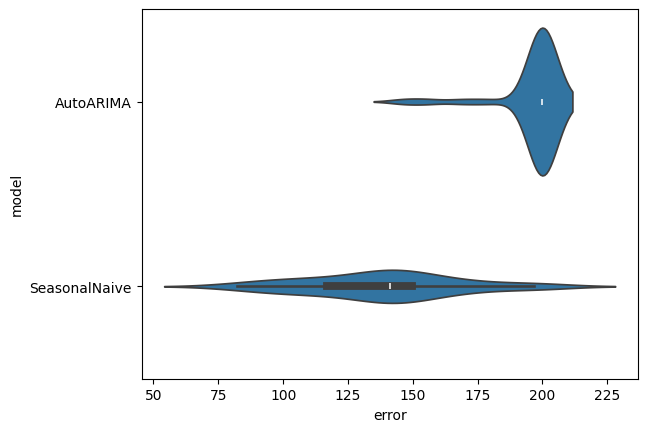

In [20]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

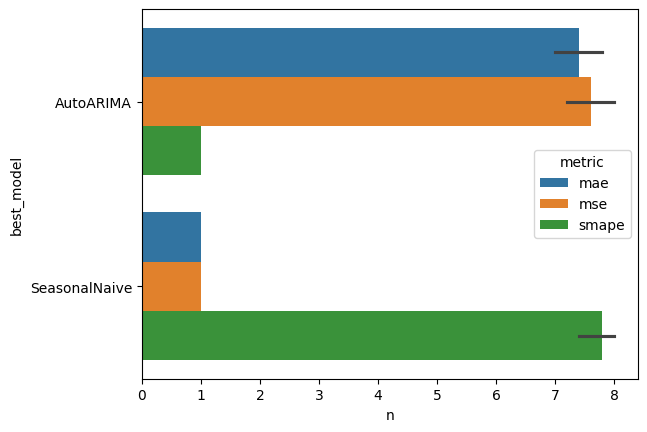

In [21]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')